# Overview
* Not concearn about the order
* Try to predict current economic phase (not forward)
* Normalized data 
* No Dimensionality  Reduncion
* Not transforming the variables
* Not lagging the variables


In [ ]:
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')
from fredapi import Fred
from utils.key import APIKEY as API_FRED
import utils_FRED_MD.model_evaluation  as me
from utils_FRED_MD.format_datasets import  get_nonNANs_fullsample



In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,confusion_matrix ,precision_score, recall_score, f1_score, classification_report ,roc_curve, roc_auc_score ,roc_curve, auc, ConfusionMatrixDisplay , RocCurveDisplay


from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import utils_FRED_MD.model_evaluation  as me
SPLIT = 0.7
SEED=42
mms = MinMaxScaler()
scaler = StandardScaler()


In [ ]:
df = get_nonNANs_fullsample()
df.head()

In [ ]:
df.tail()

In [ ]:
df.isna().any().sum()

In [ ]:
df.shape

In [ ]:
sns.countplot(x= "USREC",data=df)
plt.show()

In [ ]:
df.set_index("date")['USREC'].plot()

In [ ]:

# output_directory  ='img'
# # Define the numeric columns
# numeric_columns = df.drop(['date','USREC'],axis=1).columns

# # Loop through numeric columns
# for col in numeric_columns:
#     # Create a new figure for each numeric variable
#     plt.figure(figsize=(10, 5))
    
#     # Loop through unique classes in the categorical column
#     for category in df['USREC'].unique():
#         # Filter the DataFrame by the current category
#         category_data = df[df['USREC'] == category][col]
        
#         # Plot a histogram for the current class
#         sns.histplot(category_data, label=category, kde=True)  # You can use sns.histplot or sns.distplot
        
#     # Set plot labels, title, and legend
#     plt.xlabel(col)
#     plt.title(f'Distribution of {col} by Economic cycle')
#     plt.legend()
    
#     # Show or save the plot
#     plt.show()


#     # Save the plot as an image in the "Img" folder
#     # output_path = os.path.join(output_directory, f'{col}_distribution.pdf')
#     # plt.savefig(output_path)
    
#     # Show or clear the plot
#     plt.close()
    


------------------

## Testing each model 



### Probit

In [ ]:

X_norm = mms.fit_transform(X)
X_scaled = scaler.fit_transform(X)

In [ ]:
probit_model=smf.Probit(y,X)
result=probit_model.fit()
print(result.summary2())

In [ ]:
probit_model=smf.Probit(y,X_norm)
result=probit_model.fit(maxiter=1000)
print(result.summary2())

In [ ]:
probit_model=smf.Probit(y,X_scaled)
result=probit_model.fit()
print(result.summary2())

In [ ]:
from sklearn import metrics



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)


X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)


probit=smf.Probit(y,X)
probit.fit(maxiter=500)
print(probit.fit().summary2())

### Logistic  Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)

log_reg = LogisticRegression(class_weight='balanced',solver='liblinear',random_state = SEED)




X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

log_reg.fit(X_train_norm, y_train)

train_metrics = me.get_metrics(log_reg,y_train,X_train_norm )
test_metrics = me.get_metrics(log_reg,y_test,X_test_norm )
me.display_metrics(train_metrics,test_metrics)

me.plot_classification_metrics(log_reg,y_train,X_train_norm )
me.plot_classification_metrics(log_reg,y_test,X_test_norm )



In [ ]:
feature_importance_log_reg = pd.DataFrame({"Varariables":X.columns,"Coefs":log_reg.coef_[0]})


In [ ]:
help(LogisticRegression)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)



strat_kfold = StratifiedKFold(n_splits=10, shuffle=False)

params_log_reg = {
    'C': [0.001, 0.01, 0.1, 1, 5,10,8,30,50, 100, 1000],
    'penalty': ['elasticnet', 'l1', 'l2'],
    "solver":['saga',"lblinear"]
}



# Step 2: Perform cross-validation with hyperparameter tuning

grid_search_log_reg = GridSearchCV(LogisticRegression(class_weight='balanced',random_state = SEED), params_log_reg, cv=strat_kfold, scoring='roc_auc',n_jobs=-1)
grid_search_log_reg.fit(X_train_norm, y_train)


best_log_reg = grid_search_log_reg.best_estimator_

best_log_reg.fit(X_train_norm, y_train)

train_metrics = me.get_metrics(best_log_reg,y_train,X_train_norm )
test_metrics = me.get_metrics(best_log_reg,y_test,X_test_norm )
me.display_metrics(train_metrics,test_metrics)

me.plot_classification_metrics(best_log_reg,y_train,X_train_norm )
me.plot_classification_metrics(best_log_reg,y_test,X_test_norm )



In [ ]:
grid_search_log_reg.best_estimator_

In [ ]:
grid_search_log_reg.best_params_['penalty']

In [ ]:
grid_search_log_reg.best_params_

In [ ]:
grid_search_log_reg. best_score_

### SVM Linear

In [ ]:
from sklearn.svm import SVC
import utils_FRED_MD.model_evaluation as me

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)



strat_kfold = StratifiedKFold(n_splits=10, shuffle=False)

params_svm_linear = {
    'C': [0.001, 0.01, 0.1, 1, 5,10,8,30,50, 100, 1000]
}



# Step 2: Perform cross-validation with hyperparameter tuning

grid_search_svm_linear = GridSearchCV(SVC(kernel='linear',random_state = SEED), params_svm_linear, cv=strat_kfold, scoring='roc_auc',n_jobs=-1)
grid_search_svm_linear.fit(X_train_norm, y_train)


best_svm_linear = grid_search_svm_linear.best_estimator_

best_svm_linear.fit(X_train_norm, y_train)

train_metrics = me.get_metrics(best_svm_linear,y_train,X_train_norm )
test_metrics = me.get_metrics(best_svm_linear,y_test,X_test_norm )
me.display_metrics(train_metrics,test_metrics)

me.plot_classification_metrics(best_svm_linear,y_train,X_train_norm )
me.plot_classification_metrics(best_svm_linear,y_test,X_test_norm )



In [ ]:
grid_search_svm_linear.best_params_

### SVM Kernel trick

In [ ]:
from sklearn.svm import SVC
import utils_FRED_MD.model_evaluation as me

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)



strat_kfold = StratifiedKFold(n_splits=10, shuffle=False)

params_svm_kernel = {
    'C': [0.001, 0.01, 0.1, 1, 5,10,8,30,50, 100, 1000]
}



# Step 2: Perform cross-validation with hyperparameter tuning

grid_search_svm_kernel = GridSearchCV(SVC(kernel='rbf',random_state = SEED), params_svm_kernel, cv=strat_kfold, scoring='roc_auc',n_jobs=-1)
grid_search_svm_kernel.fit(X_train_norm, y_train)


best_svm_kernel = grid_search_svm_kernel.best_estimator_

best_svm_kernel.fit(X_train_norm, y_train)

train_metrics = me.get_metrics(best_svm_kernel,y_train,X_train_norm )
test_metrics = me.get_metrics(best_svm_kernel,y_test,X_test_norm )
me.display_metrics(train_metrics,test_metrics)

me.plot_classification_metrics(best_svm_kernel,y_train,X_train_norm )
me.plot_classification_metrics(best_svm_kernel,y_test,X_test_norm )



In [ ]:
grid_search_svm_kernel.best_params_

### Decision trees

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

strat_kfold = StratifiedKFold(n_splits=10, shuffle=False)

params_decision_tree = {
    'criterion': ['gini', 'entropy','log_loss'],
    'max_depth': [None, 10,30, 60, 90],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': ['auto', 'sqrt', 'log2', None]
}




# Step 2: Perform cross-validation with hyperparameter tuning

grid_search_DT = GridSearchCV(DecisionTreeClassifier(random_state = SEED), params_decision_tree, cv=strat_kfold, scoring='roc_auc',n_jobs=-1)
grid_search_DT.fit(X_train_norm, y_train)


best_DT = grid_search_DT.best_estimator_

best_DT.fit(X_train_norm, y_train)

train_metrics = me.get_metrics(best_DT,y_train,X_train_norm )
test_metrics = me.get_metrics(best_DT,y_test,X_test_norm )
me.display_metrics(train_metrics,test_metrics)

me.plot_classification_metrics(best_DT,y_train,X_train_norm )
me.plot_classification_metrics(best_DT,y_test,X_test_norm )



### Random Forests

In [ ]:
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



# X_train_norm = mms.fit_transform(X_train)
# X_test_norm = mms.transform(X_test)

# strat_kfold = StratifiedKFold(n_splits=10, shuffle=False)

# params_random_forest = {
#     'n_estimators': [10, 50, 100, 200],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }





# # Step 2: Perform cross-validation with hyperparameter tuning

# grid_search_RF = GridSearchCV(RandomForestClassifier(random_state=SEED), params_decision_tree, cv=strat_kfold, scoring='roc_auc',n_jobs=-1)
# grid_search_RF.fit(X_train_norm, y_train)


# best_RF = grid_search_RF.best_estimator_

# best_RF.fit(X_train_norm, y_train)

# train_metrics = me.get_metrics(best_RF,y_train,X_train_norm )
# test_metrics = me.get_metrics(best_RF,y_test,X_test_norm )
# me.display_metrics(train_metrics,test_metrics)

# me.plot_classification_metrics(best_RF,y_train,X_train_norm )
# me.plot_classification_metrics(best_RF,y_test,X_test_norm )



-----


##  Consolidating the experiments

In [ ]:
X = df.drop(['USREC','date'],axis=1)
y = df['USREC']

In [ ]:


# %load_ext autoreload
# %autoreload 2

# from utils_FRED_MD.ml_execution import evaluate_models

# results = evaluate_models(X,y,scoring='roc_auc')


# train_results = pd.concat([ i['Metrics_Train'] for i in results] ).sort_values('Area Under the Curve',ascending=False)

# test_results = pd.concat([ i['Metrics_Test'] for i in results] ).sort_values('Area Under the Curve',ascending=False)


In [ ]:


%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')



from utils_FRED_MD.ml_execution import evaluate_models


In [ ]:


def ml_pipeline(original_dataframe,shift_target=0,**kwargs):
    modeling_dataframe = original_dataframe.copy()
    modeling_dataframe['Target'] = modeling_dataframe['USREC'].shift(-shift_target)
    modeling_dataframe.dropna(inplace=True)
    X = modeling_dataframe.drop(['USREC','date','Target'],axis=1)
    y = modeling_dataframe['Target']
    results = evaluate_models(X,y,scoring='roc_auc',**kwargs)


    train_stats = pd.concat([ i['Metrics_Train'] for i in results] ).sort_values('Area Under the Curve',ascending=False)
    
    test_stats = pd.concat([ i['Metrics_Test'] for i in results] ).sort_values('Area Under the Curve',ascending=False)

    train_test_stats_df = pd.concat([train_stats ,test_stats])

    train_test_stats_df['Prediction_ahead'] = shift_target
    return results , train_test_stats_df


all_results = []
list_table_results = []






for i in [0,3,6,12]:
    roc_save_path = 'img/' + f"Predictions_{i}_ahead"
    
    iteration_results = ml_pipeline(df,shift_target=i,save_path=roc_save_path)
    
    list_results =  iteration_results[0]
    all_results.append(list_results)

    table_results = iteration_results[1]
    list_table_results.append(table_results)
    print("Predictions ", i,' days done')



In [21]:
consolidated_results = pd.concat(list_table_results).reset_index(drop=True)
consolidated_results.to_excel("results/consolidated_results_grid_search.xlsx")

Best parameters for RandomForest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Train roc_auc for RandomForest: 0.9791666666666666
Folder already exists at: img/classification_metrics/
Folder already exists at: img/classification_metrics/
Predictions  0  days done
Best parameters for RandomForest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Train roc_auc for RandomForest: 0.9566666666666667
Folder already exists at: img/classification_metrics/
Folder already exists at: img/classification_metrics/
Predictions  3  days done
Best parameters for RandomForest: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Train roc_auc for RandomForest: 0.8993650793650794
Folder already exists at: img/classification_metrics/
Folder already exists at: img/classification_metrics/
Predictions  6  days d

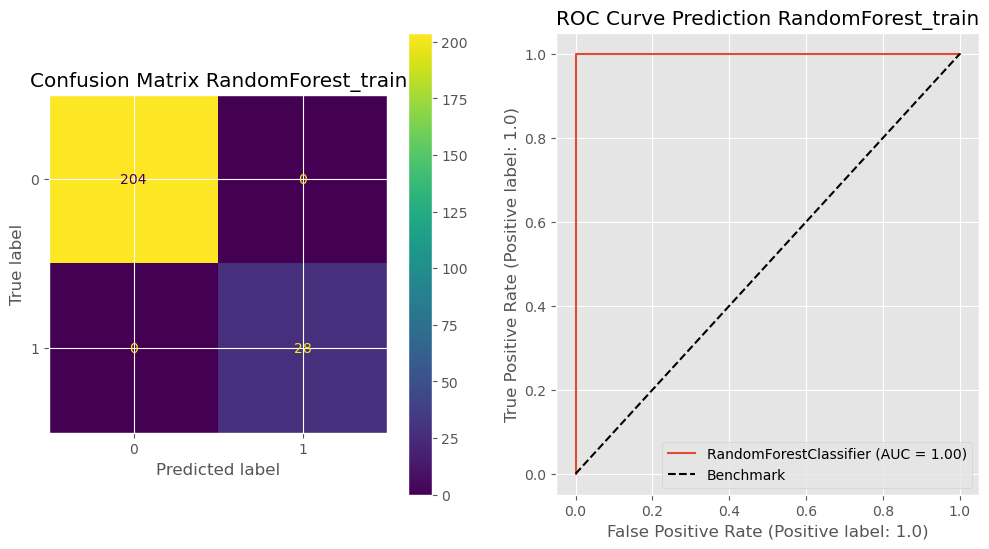

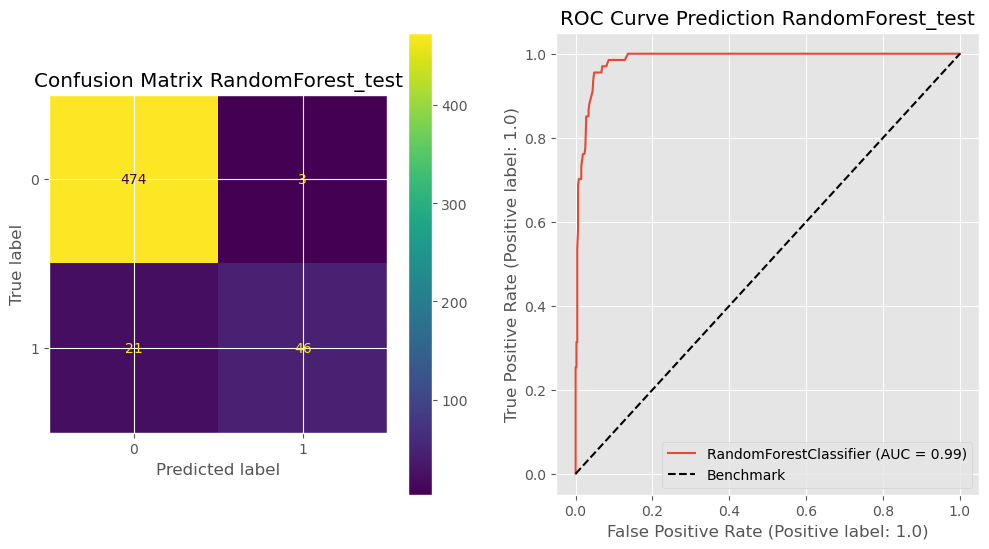

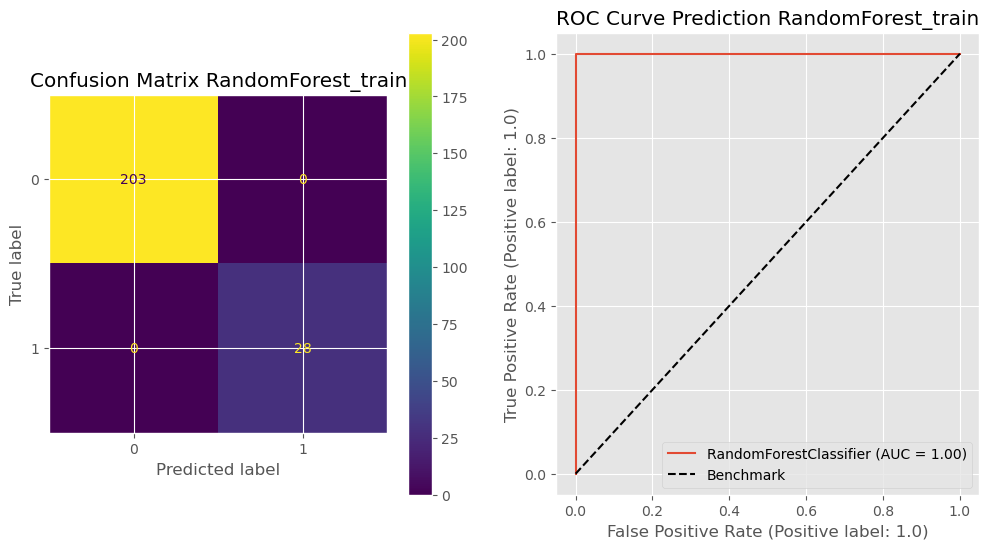

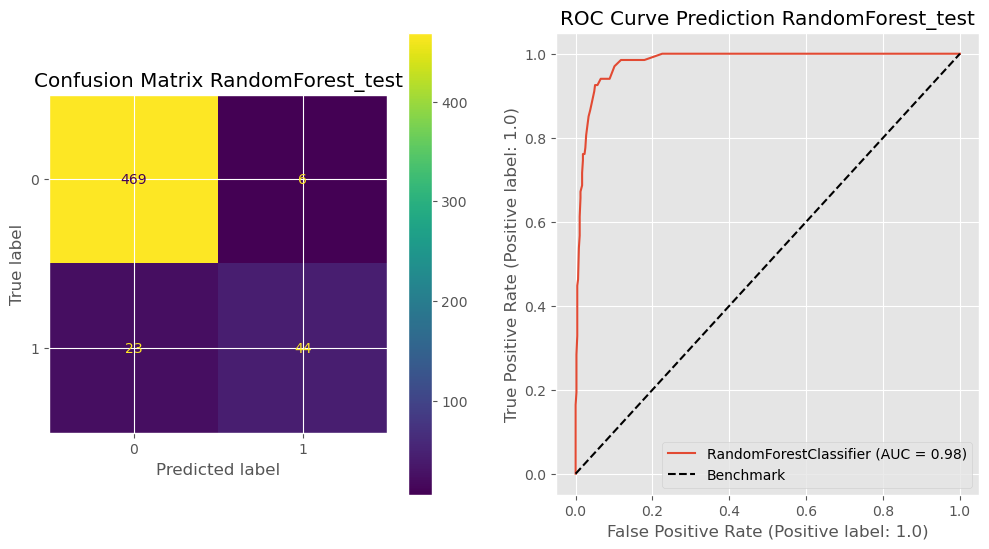

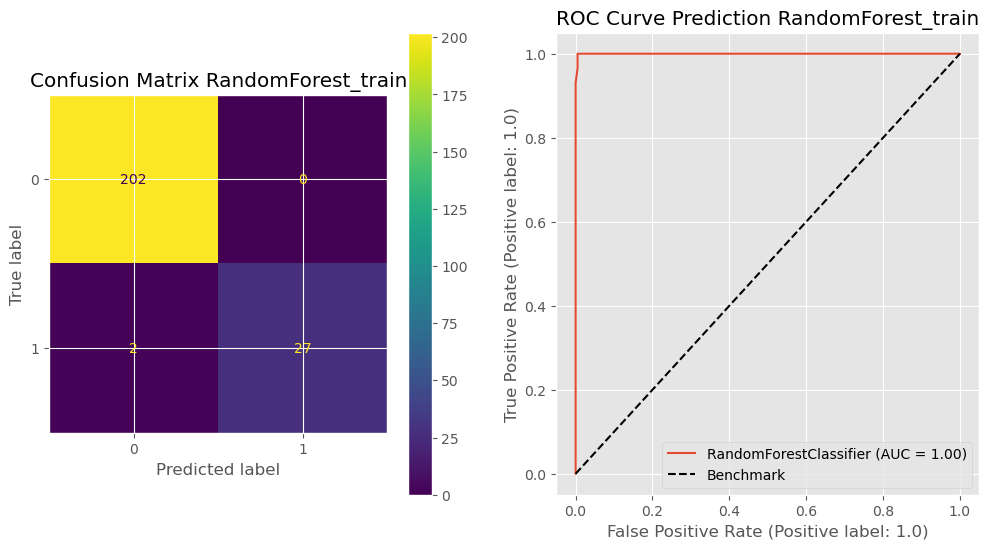

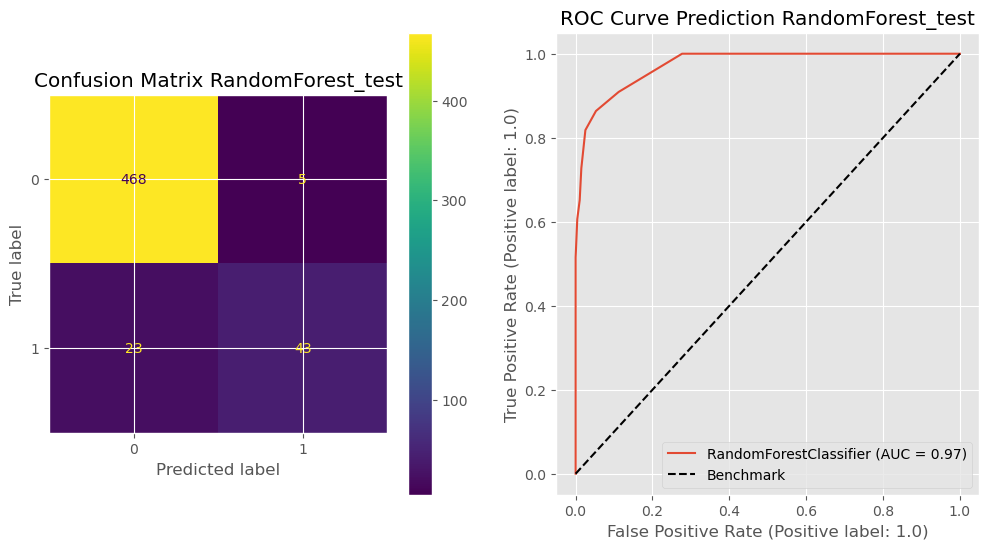

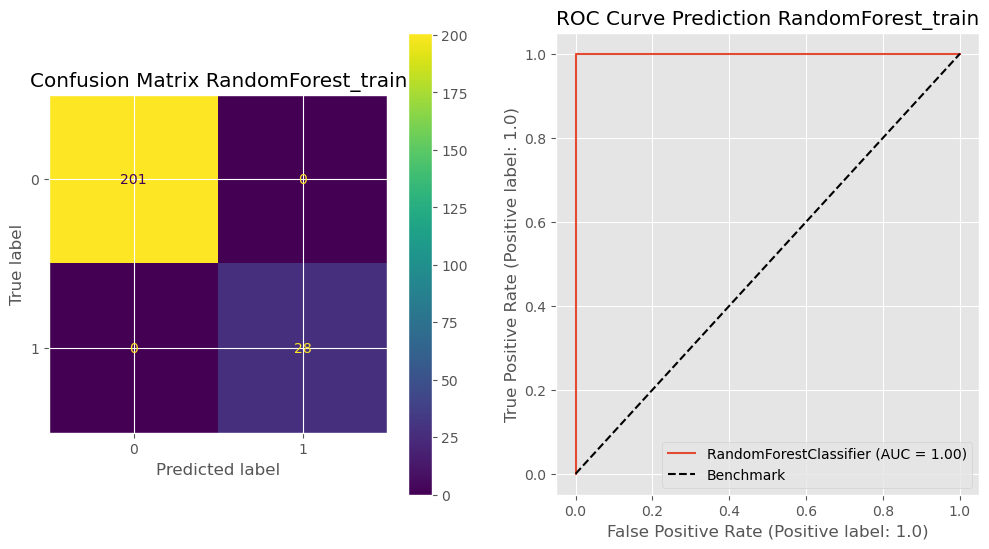

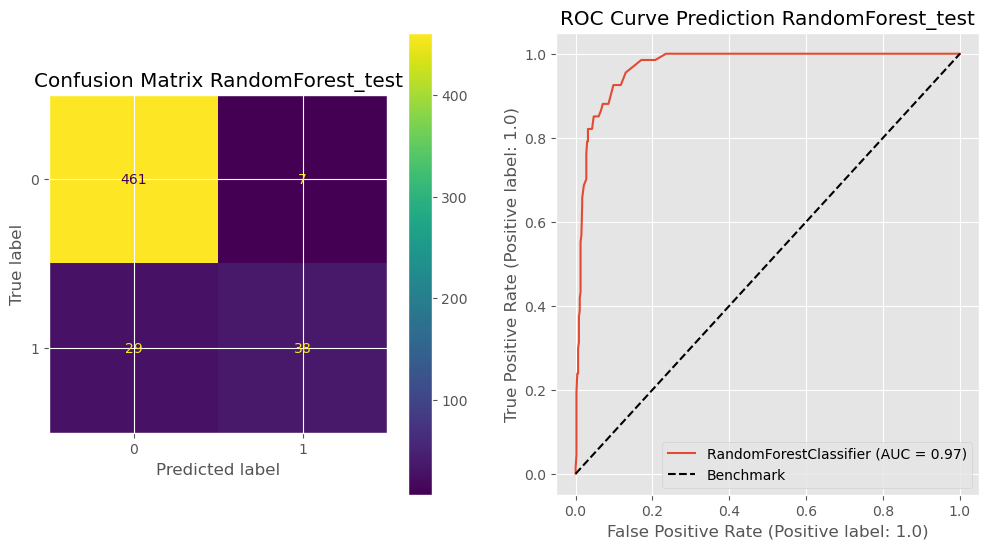

In [22]:
from sklearn.ensemble import RandomForestClassifier

all_results_v2 = []
list_table_results_v2 = []

model_set_rf = ("RandomForest",RandomForestClassifier(),{'n_estimators': [10, 50, 100, 200, 500], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),


for i in [0,3,6,12]:
    roc_save_path = 'img/' + f"Predictions_{i}_ahead"
    
    iteration_results_v2 = ml_pipeline(df,shift_target=i,save_path=roc_save_path,models_and_params=model_set_rf)
    
    list_results_v2 =  iteration_results_v2[0]
    all_results_v2.append(list_results_v2)

    table_results_v2 = iteration_results_v2[1]
    list_table_results_v2.append(table_results_v2)
    print("Predictions ", i,' days done')



Best parameters for DummyClassifier: {'strategy': 'most_frequent'}
Best Train roc_auc for DummyClassifier: 0.5
Folder already exists at: img/classification_metrics/
Folder already exists at: img/classification_metrics/
Predictions  0  days done
Best parameters for DummyClassifier: {'strategy': 'stratified'}
Best Train roc_auc for DummyClassifier: 0.5048809523809523
Folder already exists at: img/classification_metrics/
Folder already exists at: img/classification_metrics/
Predictions  3  days done
Best parameters for DummyClassifier: {'strategy': 'most_frequent'}
Best Train roc_auc for DummyClassifier: 0.5
Folder already exists at: img/classification_metrics/
Folder already exists at: img/classification_metrics/
Predictions  6  days done
Best parameters for DummyClassifier: {'strategy': 'most_frequent'}
Best Train roc_auc for DummyClassifier: 0.5
Folder already exists at: img/classification_metrics/
Folder already exists at: img/classification_metrics/
Predictions  12  days done


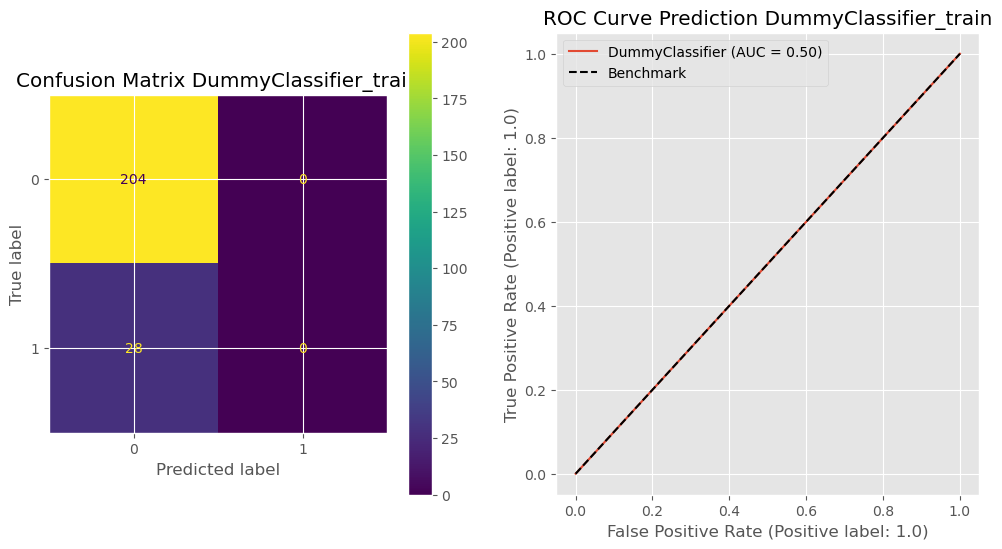

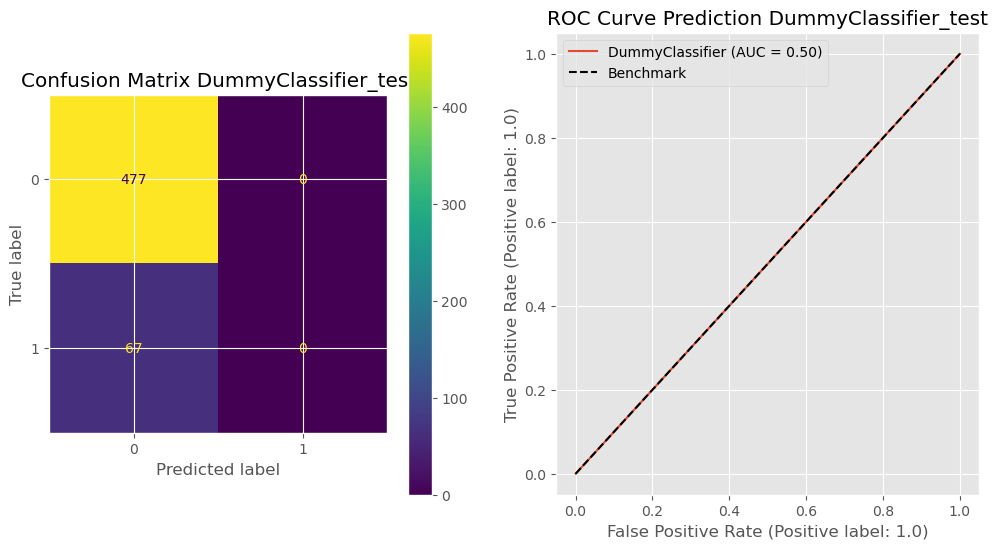

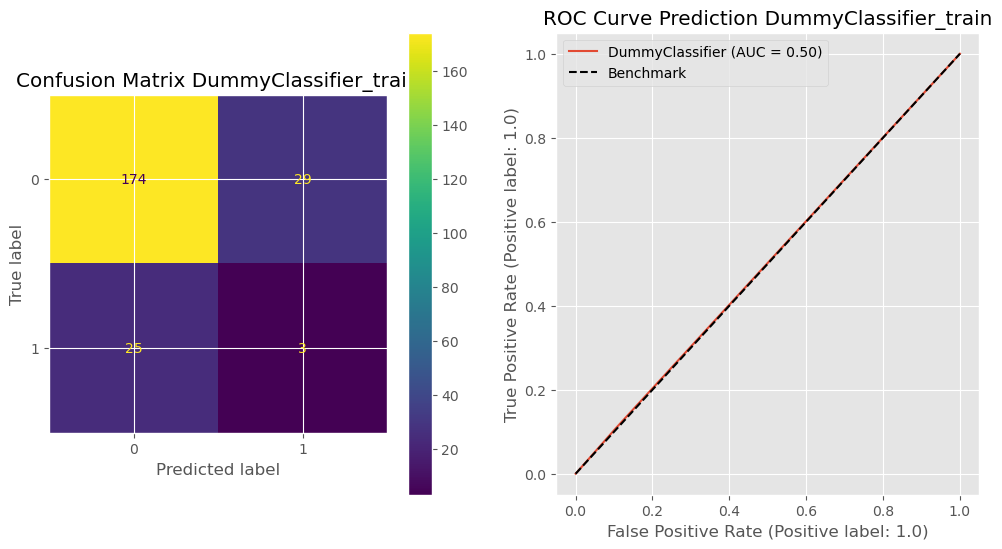

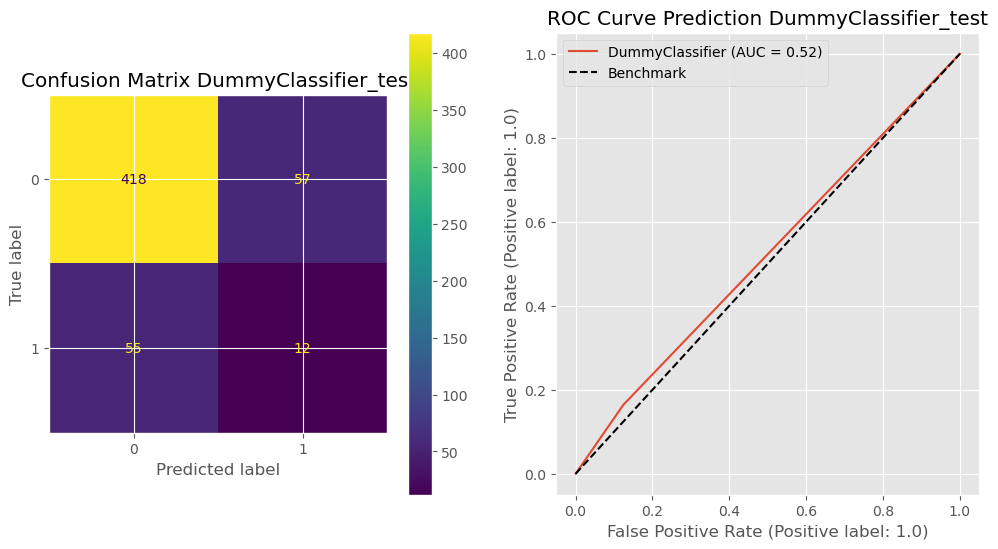

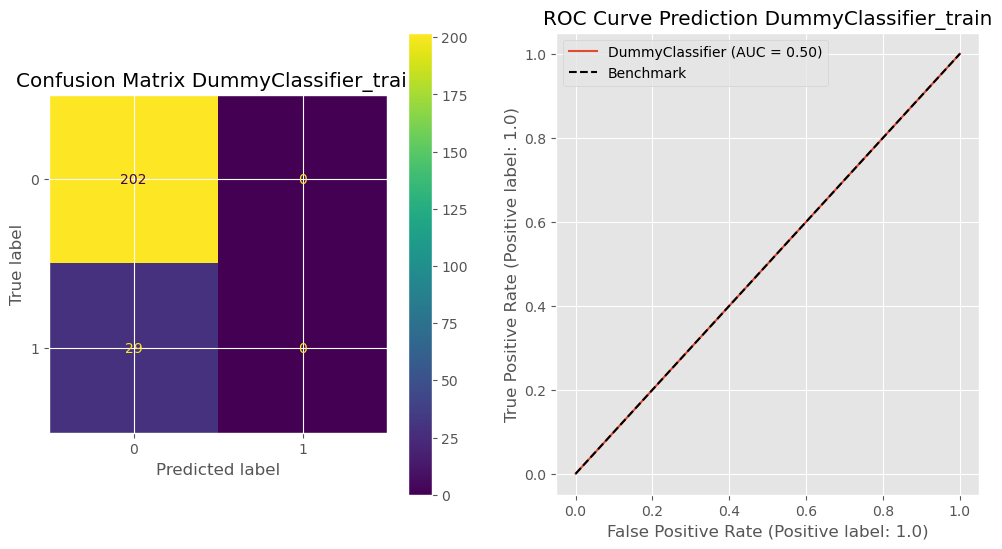

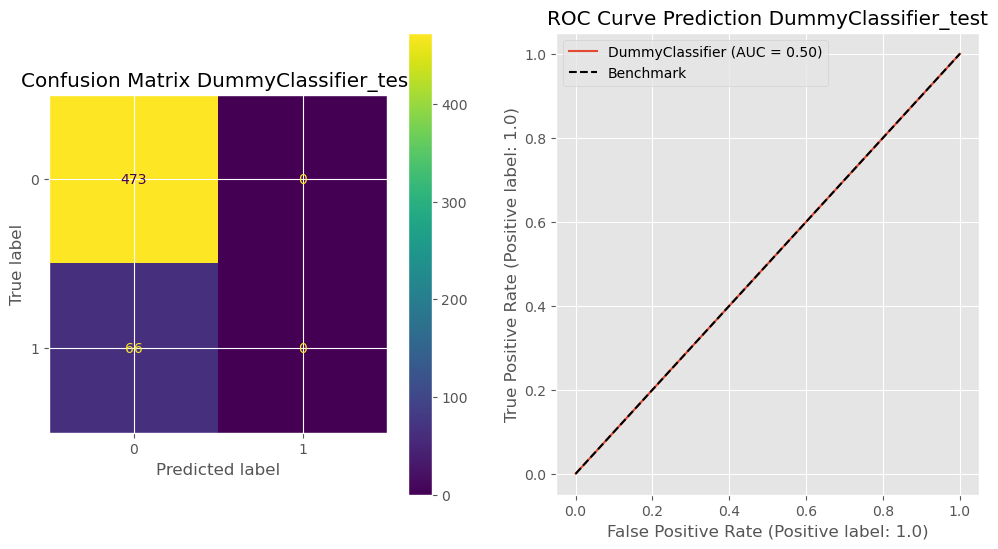

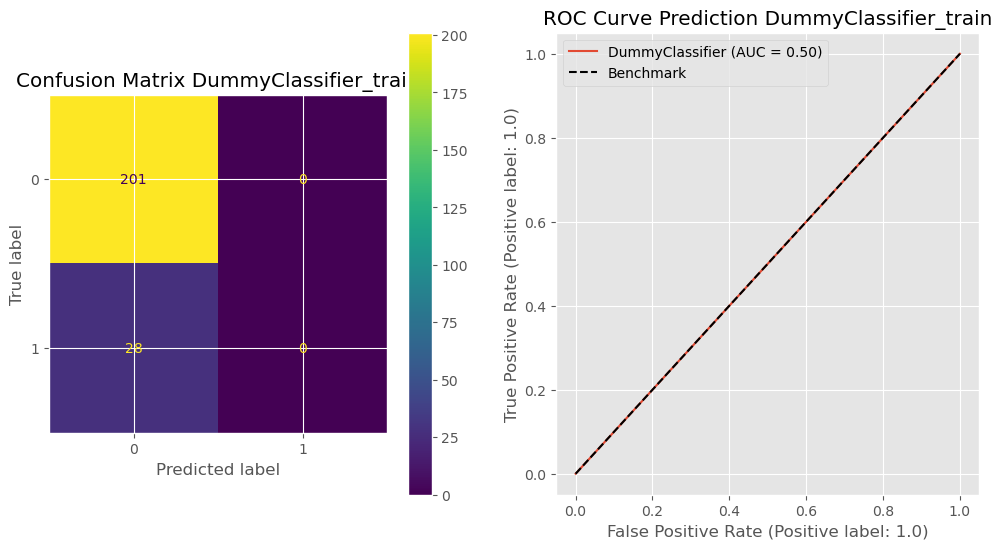

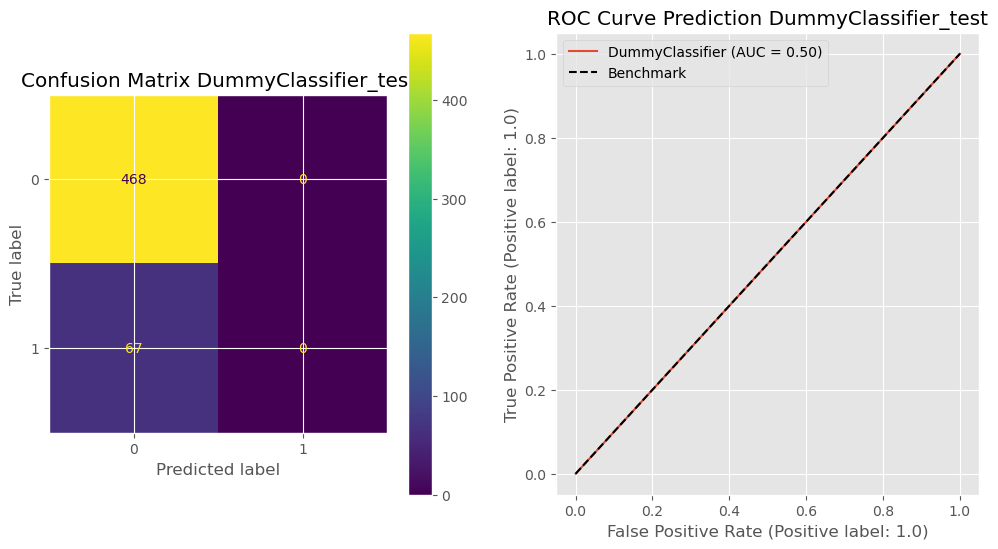

In [24]:
from sklearn.dummy import DummyClassifier

all_results_dummy = []
list_table_results_dummy = []

model_setdummy = ("DummyClassifier",DummyClassifier(),{'strategy':["most_frequent", "prior", "stratified", "uniform", "constant"]}),


for i in [0,3,6,12]:
    roc_save_path = 'img/' + f"Predictions_{i}_ahead"
    
    iteration_results_dummy = ml_pipeline(df,shift_target=i,save_path=roc_save_path,models_and_params=model_setdummy)
    
    list_results_dummy =  iteration_results_dummy[0]
    all_results_dummy.append(list_results_dummy)

    table_results_dummy = iteration_results_dummy[1]
    list_table_results_dummy.append(table_results_dummy)
    print("Predictions ", i,' days done')



In [25]:
consolidated_results_rf = pd.concat(list_table_results_v2).reset_index(drop=True)
consolidated_results_rf

,Model,Accuracy,Precision,Sensitivity,Specificity,Balanced Accuracy,Kappa,F1-Score,Area Under the Curve,Gini,Dataset_partition,Prediction_ahead
0,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,Train,0
1,RandomForestClassifier,0.955882,0.938776,0.686567,0.993711,0.840139,0.769076,0.793103,0.986185,0.97,Test,0
2,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,Train,3
3,RandomForestClassifier,0.946494,0.880000,0.656716,0.987368,0.822042,0.722855,0.752137,0.981398,0.96,Test,3
4,RandomForestClassifier,0.991342,1.000000,0.931034,1.000000,0.965517,0.959367,0.964286,0.999744,1.00,Train,6
5,RandomForestClassifier,0.948052,0.895833,0.651515,0.989429,0.820472,0.726148,0.754386,0.973477,0.95,Test,6
6,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,Train,12
7,RandomForestClassifier,0.932710,0.844444,0.567164,0.985043,0.776103,0.642605,0.678571,0.971345,0.94,Test,12


In [26]:
consolidated_results_dummy = pd.concat(list_table_results_dummy).reset_index(drop=True)
consolidated_results_dummy

,Model,Accuracy,Precision,Sensitivity,Specificity,Balanced Accuracy,Kappa,F1-Score,Area Under the Curve,Gini,Dataset_partition,Prediction_ahead
0,DummyClassifier,0.879310,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.500000,0.00,Train,0
1,DummyClassifier,0.876838,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.500000,0.00,Test,0
2,DummyClassifier,0.779221,0.151515,0.178571,0.862069,0.520320,0.037736,0.163934,0.548645,0.10,Train,3
3,DummyClassifier,0.800738,0.211268,0.223881,0.882105,0.552993,0.103336,0.217391,0.488028,-0.02,Test,3
4,DummyClassifier,0.874459,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.500000,0.00,Train,6
5,DummyClassifier,0.877551,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.500000,0.00,Test,6
6,DummyClassifier,0.877729,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.500000,0.00,Train,12
7,DummyClassifier,0.874766,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.500000,0.00,Test,12


In [27]:
results_grid = pd.concat([consolidated_results,consolidated_results_rf,consolidated_results_dummy]).reset_index(drop=True)
results_grid.to_excel("results/results_grid.xlsx")